In [1]:
import Gen_data, Utils, TL_Training, Outlier_detection_criteria, Compute_solution_path, Plot

import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
def run_SIRo_TL():
	nS = 100
	nT = 50
	p = 200

	gamma = 1.0
	alpha = 0.5
	xi_threshold = 1.5
	threshold = 20

	K = 1
	N = nS * K + nT

	X, X0, Y, Y0, Sigma = Gen_data.generate_data(p, nS, nT, K)
	
	N, p = X.shape
	nT = X0.shape[0]

	lambda_w = np.sqrt(np.log(p) / N) * 9.0
	lambda_d = np.sqrt(np.log(p) / nT) * 4.5

	P_w, K_w, q0_w, q1_w, S_w, h_w, u0_w, u1_w = Gen_data.Construct_matrix(X, Y, gamma)

	info_w = TL_Training.training_qp_w(P_w, K_w, q0_w, q1_w, S_w, h_w, X, lambda_w, alpha)
	if info_w == None:
		return None

	w_hat_qp = info_w['w_plus'] - info_w['w_minus']
	Q_w = info_w['Q']
	f_w = info_w['f']
	t_hat_w = info_w['t_value']
	prob_w = info_w['Problem']
	v_lag_w = prob_w.constraints[0].dual_value

	KKT_w = TL_Training.check_KKT(Q_w, f_w, S_w, h_w, t_hat_w, v_lag_w)
	if not KKT_w:
		return None

	P_d, K_d, q0_d, q1_d, S_d, h_d, u0_d, u1_d = Gen_data.Construct_matrix(X0, Y0, gamma)

	h_d[: nT] = Y0 - X0 @ w_hat_qp
	h_d[nT : 2 * nT] = - (Y0 - X0 @ w_hat_qp)
	h_d[3 * nT : 4 * nT] = gamma * np.ones(nT)

	info_d = TL_Training.training_qp_delta(P_d, K_d, q0_d, q1_d, S_d, h_d, X0, lambda_d, alpha)
	if info_d == None:
		return None

	d_hat_qp = info_d['d_plus'] - info_d['d_minus']
	Q_d = info_d['Q']
	f_d = info_d['f']
	t_hat_d = info_d['t_value']

	prob_d = info_d['Problem']
	v_lag_d = prob_d.constraints[0].dual_value

	KKT_d = TL_Training.check_KKT(Q_d, f_d, S_d, h_d, t_hat_d, v_lag_d)
	if not KKT_d:
		return None

	beta_hat_Or = w_hat_qp + d_hat_qp
	res_target = Y0 - X0 @ beta_hat_Or

	outlier_mask = np.abs(res_target) >= xi_threshold
	outliers_obs = []
	for i, o in enumerate(outlier_mask):
		if o:
			outliers_obs.append(i)

	if len(outliers_obs) == 0:
		print('No Outliers Obs')
		return None

	i_Outlier = np.random.choice(outliers_obs)

	Y0_mask = Utils.construct_Y0_mask(nT, N)

	etai, etaT_Yobs = Utils.construct_test_statistic(i_Outlier, X, X0, Y, outliers_obs)
	a_y, b_y, eta = Utils.calculate_a_b(etai, Y, Sigma)

	threshold = threshold * (np.sqrt(eta))
	
	list_zk, list_g_beta, list_f_beta = Compute_solution_path.compute_solution_path(X, X0, Y0_mask, lambda_w, lambda_d, alpha, gamma, a_y, b_y, xi_threshold, threshold)

	# if list_zk == None or list_zk == []:
	# 	return None

	final_intervals = Outlier_detection_criteria.Outlier_detection_intervals(list_zk, list_f_beta, list_g_beta, xi_threshold, outliers_obs)

	if final_intervals == []:
		return None

	tn_mu = 0
	pivot = Utils.compute_pivot(final_intervals, etai, etaT_Yobs, Sigma, tn_mu)

	return pivot

--------------------------------------------------------------------------------------------------------
Iter: 1, P_value: 0.23198201307822833

--------------------------------------------------------------------------------------------------------
Iter: 2, P_value: 0.7872676050179082

--------------------------------------------------------------------------------------------------------
Iter: 3, P_value: 0.7575140495694295

--------------------------------------------------------------------------------------------------------
Iter: 4, P_value: 0.29578746022202784

--------------------------------------------------------------------------------------------------------
Iter: 5, P_value: 0.3686716885809005

--------------------------------------------------------------------------------------------------------
Iter: 6, P_value: 0.7984238245988491

--------------------------------------------------------------------------------------------------------
Iter: 7, P_value: 0.752730646938997

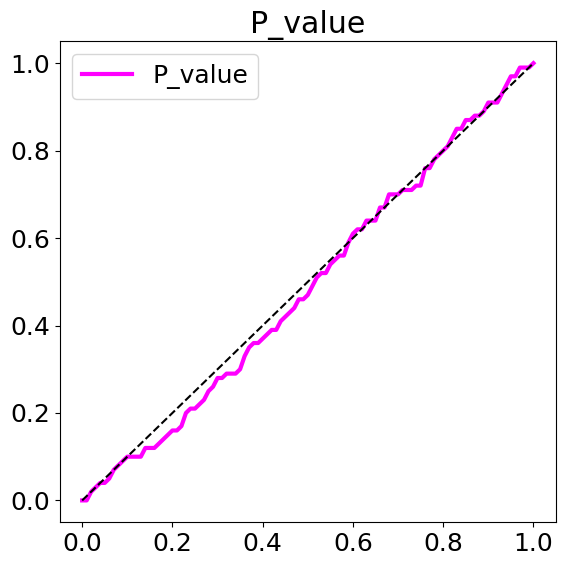

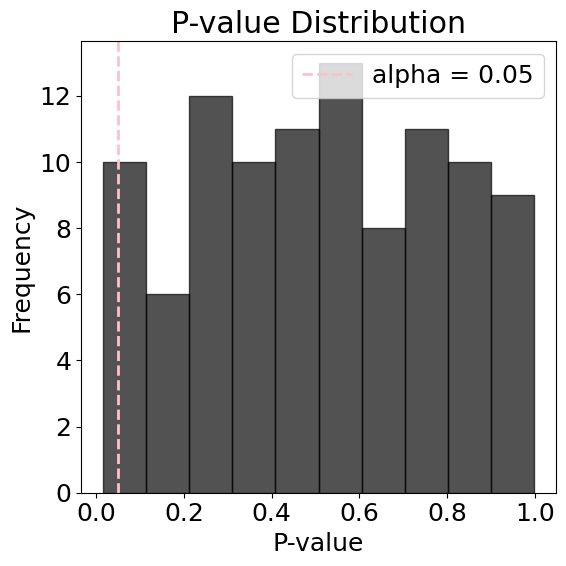

In [4]:
if __name__ == '__main__':
	max_iteration = 100
	alpha = 0.05
	list_p_value = []

	iteration = 1

	while iteration <= max_iteration:
	    pivot = run_SIRo_TL()

	    if pivot is not None:
	        p_value = 2 * min(1 - pivot, pivot)
	        list_p_value.append(p_value)

	        print('--------------------------------------------------------------------------------------------------------')
	        print(f'Iter: {iteration}, P_value: {p_value}')
	        print()

	        iteration += 1

	Plot.plot_ecdf_p_value(list_p_value)
	Plot.plot_hist_p_value(list_p_value)

In [6]:
from scipy.stats import kstest

statistic, pval = kstest(list_p_value, 'uniform')

print("KS statistic =", statistic)
print("p-value =", pval)

KS statistic = 0.05497601056051532
p-value = 0.9066239938245155
